# Nature CNN Recreation

In [1]:
%cd ..

c:\Users\Gebruiker\Documents\YEAR 3\Neural Networks\traffic-sign-classification


## Data

In [ ]:
from nn.utils import one_hot_encode, export_encoded_labels
from dataio.gtsrb_dataset import GTSRBDataset
import numpy as np

chosen_classes = {1, 2, 10, 13, 38}

dataset = GTSRBDataset()
labels = dataset.labels_data

filtered_indices = [i for i, (_, label) in enumerate(labels) if label in chosen_classes]

class_indices = {cls: [] for cls in chosen_classes}
for idx in filtered_indices:
    _, label = labels[idx]
    class_indices[label].append(idx)

clipped_indices = []
for cls in chosen_classes:
    indices = np.array(class_indices[cls])
    np.random.shuffle(indices)
    if len(indices) > 2500:
        indices = indices[:2500]
    clipped_indices.extend(indices)

clipped_indices = np.array(clipped_indices)
np.random.shuffle(clipped_indices)

label_to_index = {label: idx for idx, label in enumerate(chosen_classes)}
mapped_labels = np.array([label_to_index[labels[i][1]] for i in clipped_indices])

num_classes = len(chosen_classes)
one_hot_labels = one_hot_encode(mapped_labels, num_classes)

filtered_csv_path = export_encoded_labels(
    dataset=GTSRBDataset(),
    chosen_classes=chosen_classes,
    clipped_indices=list(clipped_indices),
    output_name="filtered_labels_encoded.csv"
)

filtered_dataset = GTSRBDataset(labels="filtered_labels_encoded.csv")
num_samples = len(filtered_dataset)

train_end = int(0.85 * num_samples)
train_split = list(range(train_end))
test_split = list(range(train_end, num_samples))

In [3]:
from dataio.transforms import ToCompose, ToGrayscale, ToResize, ToTensor, ToNormalize
from dataio.dataloader import DataLoader

# Set up the data transformations to match the original nature CNN.
train_transforms = ToCompose([
    ToGrayscale(),
    ToResize(size=28),
    ToTensor(),
    ToNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
val_transforms = ToCompose([
    ToGrayscale(),
    ToResize(size=28),
    ToTensor(),
    ToNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Set up the datasets.
train_dataset = GTSRBDataset(
    indices=train_split,
    split="train",
    transforms=train_transforms,
    labels="filtered_labels_encoded.csv"
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = GTSRBDataset(
    indices=test_split,
    split="test",
    transforms=val_transforms,
    labels="filtered_labels_encoded.csv"
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Architecture

In [4]:
from nn.layers.conv2d import Conv2D
from nn.layers.flatten import Flatten
from nn.layers.linear import Linear
from nn.layers.maxpool2d import MaxPool2D
from nn.layers.sequential import Sequential
from nn.layers.activation import Activation
from nn.activations import relu
from nn.__init__ import he_init

# Set up model, matching the original CNN as best as possible.
# The model has ReLU activations and He initialisation, because otherwise gradients vanish immediately!
layers = [
    Conv2D(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0, weight_init=he_init),
    Activation(relu),
    MaxPool2D(pool_size=2, stride=2),
    Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, weight_init=he_init),
    Activation(relu),
    MaxPool2D(pool_size=2, stride=2),
    Flatten(),
    Linear(in_features=256, out_features=120, weight_init=he_init),
    Activation(relu),
    Linear(in_features=120, out_features=84, weight_init=he_init),
    Activation(relu),
    Linear(in_features=84, out_features=5, weight_init=he_init)
]
model = Sequential(layers)


In [5]:
# Get the parameters from the model.
param_list = []
for layer in model.layers:
    for name, param in layer.params().items():
        param_list.append((layer, name, param))

from nn.optim import Momentum

# Initialise the optimiser.
# The original CNN used SGD with Momentum.
optimiser = Momentum(param_list, lr=0.01, weight_decay=0.0005)

from nn.loss import mse

# Define the loss function.
# The original CNN used MSE.
loss_fn = mse

## Training

In [ ]:
from train import train

# Train the model.
train_losses, _, train_accs, _ = train(
    model,
    train_loader,
    val_loader=None,
    loss_fn=loss_fn,
    optimiser=optimiser,
    num_epochs=30
)

Epoch 1/30 [Train]: 0it [00:00, ?it/s]

Epoch 1/30 [Train]: 146it [01:23,  2.26it/s, acc=0.25, loss=0.163]  

## Evaluation

In [ ]:
from evaluate import evaluate

# Evaluate the model.
test_loss, test_acc = evaluate(model, test_loader, loss_fn)

Test Loss: 1.4395, Test Accuracy: 0.2023


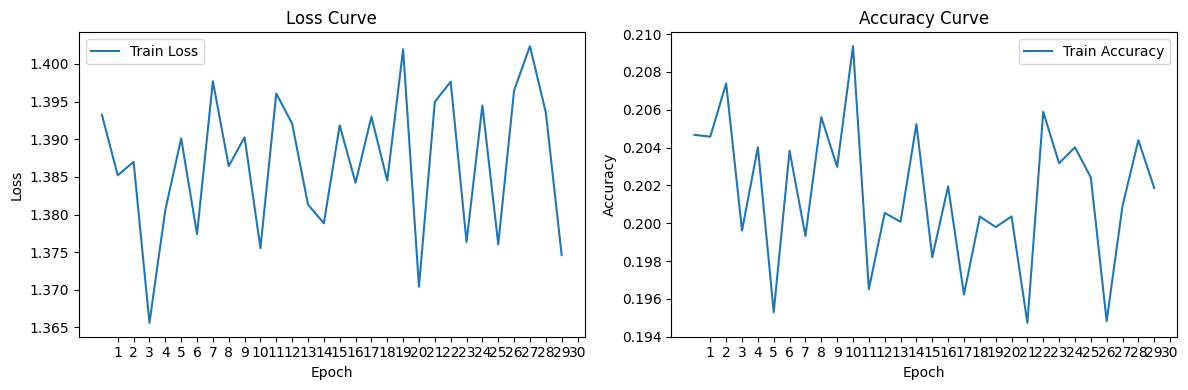

In [ ]:
import viz

# Plot the loss and accuracy.
viz.plot_curves(train_losses, train_accs)

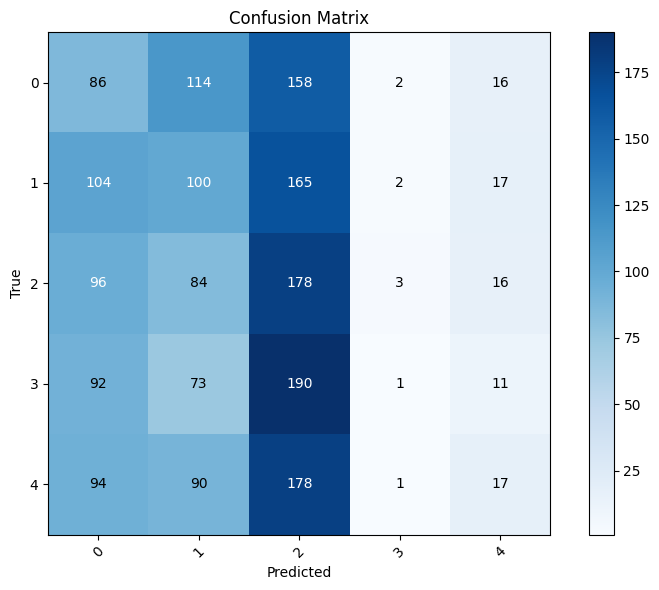

In [ ]:
# Collect all true labels and predictions
all_true_labels = []
all_predictions = []

for batch_data, batch_labels in test_loader:
    predictions = np.argmax(model.forward(batch_data), axis=1)
    all_true_labels.extend(batch_labels)
    all_predictions.extend(predictions)

# Define the five classes of interest
classes = {0, 1, 2, 3, 4}  # Replace with the actual class labels of interest

# Filter the true labels and predictions to include only the classes of interest
filtered_true_labels = []
filtered_predictions = []

for true, pred in zip(all_true_labels, all_predictions):
    if true in classes and pred in classes:
        filtered_true_labels.append(true)
        filtered_predictions.append(pred)

# Plot the confusion matrix using the filtered data
viz.plot_confusion_matrix(
    np.array(filtered_true_labels),
    np.array(filtered_predictions),
    classes
)

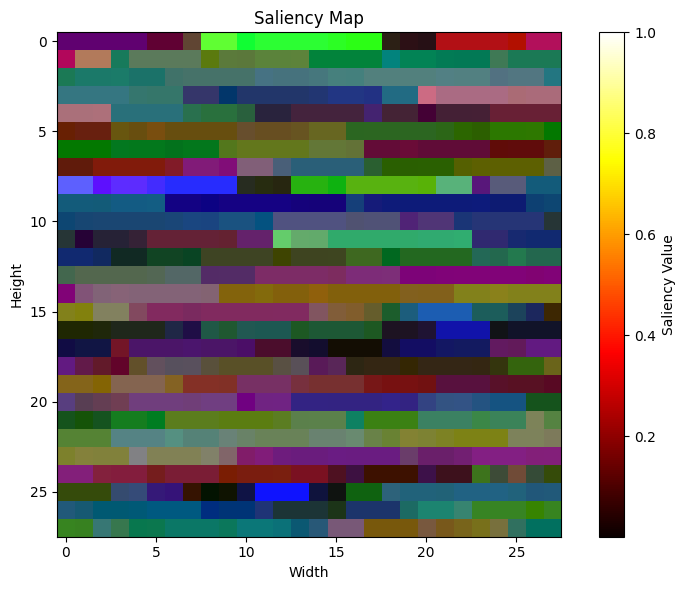

In [ ]:
# Compute and plot saliency maps for the first sample.
input_sample = batch_data[0]
saliency_map = viz.compute_saliency_map(model, input_sample)
viz.plot_saliency_map(saliency_map)

In [ ]:
import csv
import numpy as np
from evaluate import predict
from nn.utils import compute_accuracy

# Predict.
predictions = predict(model, test_loader)

# Load true labels from the CSV file.
all_labels = []
with open('./data/gtsrb/filtered_labels_encoded.csv', mode='r') as file:
    reader = csv.DictReader(file, delimiter=';')
    for row in reader:
        all_labels.append(int(row['ClassId']))

# Convert the list of all labels to a NumPy array for easier slicing
all_labels = np.array(all_labels)

# Determine the number of predictions dynamically
num_predictions = len(predictions)

# Extract the corresponding number of labels from the end of the array
test_labels = all_labels[-num_predictions:]

# Compute accuracy.
accuracy = compute_accuracy(predictions, test_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.1917372881355932
